In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/software/anaconda/5.0.1b/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['resize', 'imshow', 'seed', 'random', 'imread', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
import time

start_time = time.time()
tcurrent   = start_time

In [10]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../00.data/extracted/stage1_train/'
TEST_PATH = '../00.data/extracted/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 423 # original seed: 42
random.seed = seed
np.random.seed = seed

In [11]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [12]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [13]:
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [03:37<00:00,  3.08it/s]


In [14]:
# Get and resize test images

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []

In [15]:
print('Getting and resizing test images ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 40.36it/s]

Done!


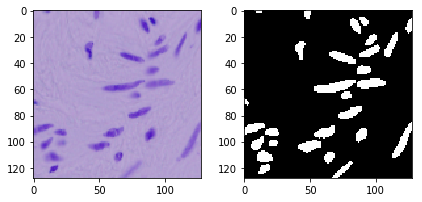

In [19]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.subplot(121)
imshow(X_train[ix])
plt.subplot(122)
imshow(np.squeeze(Y_train[ix]));

In [20]:
# Define IoU metric

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### Build U-Net model

In [22]:
import tensorflow as tf

In [23]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [24]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 8)  224         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 8)  584         conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [25]:
model_path = '../02.model/model-dsbowl2018-1.h5'

In [26]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

# setup
n_epochs  = 100
val_split = 0.12

# fitting
results = model.fit(X_train, Y_train, 
                    validation_split=val_split, 
                    batch_size=8, epochs=n_epochs, 
                    callbacks=[earlystopper, checkpointer])

Train on 589 samples, validate on 81 samples
Epoch 1/100
589/589 [==============================] - 15s 25ms/step - loss: 0.4843 - mean_iou: 0.4223 - val_loss: 0.4058 - val_mean_iou: 0.4242
Epoch 2/100
589/589 [==============================] - 7s 12ms/step - loss: 0.2996 - mean_iou: 0.4230 - val_loss: 0.2925 - val_mean_iou: 0.4239
Epoch 3/100
589/589 [==============================] - 7s 12ms/step - loss: 0.2166 - mean_iou: 0.4242 - val_loss: 0.2337 - val_mean_iou: 0.4250
Epoch 4/100
589/589 [==============================] - 7s 12ms/step - loss: 0.1758 - mean_iou: 0.4302 - val_loss: 0.1872 - val_mean_iou: 0.4420
Epoch 5/100
589/589 [==============================] - 7s 12ms/step - loss: 0.1338 - mean_iou: 0.4657 - val_loss: 0.1464 - val_mean_iou: 0.4927
Epoch 6/100
589/589 [==============================] - 7s 12ms/step - loss: 0.1200 - mean_iou: 0.5150 - val_loss: 0.1387 - val_mean_iou: 0.5357
Epoch 7/100
589/589 [==============================] - 7s 12ms/step - loss: 0.1025 - mean_

Epoch 28/100
589/589 [==============================] - 7s 12ms/step - loss: 0.0748 - mean_iou: 0.7691 - val_loss: 0.0924 - val_mean_iou: 0.7706
Epoch 29/100
589/589 [==============================] - 7s 11ms/step - loss: 0.0721 - mean_iou: 0.7721 - val_loss: 0.0944 - val_mean_iou: 0.7735
Epoch 30/100
589/589 [==============================] - 7s 11ms/step - loss: 0.0727 - mean_iou: 0.7750 - val_loss: 0.0937 - val_mean_iou: 0.7763
Epoch 31/100
589/589 [==============================] - 7s 12ms/step - loss: 0.0716 - mean_iou: 0.7777 - val_loss: 0.0923 - val_mean_iou: 0.7790
Epoch 32/100
589/589 [==============================] - 7s 12ms/step - loss: 0.0717 - mean_iou: 0.7803 - val_loss: 0.0902 - val_mean_iou: 0.7815
Epoch 33/100
589/589 [==============================] - 7s 12ms/step - loss: 0.0698 - mean_iou: 0.7827 - val_loss: 0.0873 - val_mean_iou: 0.7839
Epoch 34/100
589/589 [==============================] - 7s 11ms/step - loss: 0.0726 - mean_iou: 0.7850 - val_loss: 0.0891 - val_me

#### Predict on train, val and test

In [27]:
model = load_model(model_path, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 0s 2ms/step


#### Threshold predictions

In [28]:
thr = 0.50
preds_train_t = (preds_train > thr).astype(np.uint8)
preds_val_t = (preds_val > thr).astype(np.uint8)
preds_test_t = (preds_test > thr).astype(np.uint8)

#### Create list of upsampled test masks

In [29]:
preds_test_upsampled = []

for i in range(len(preds_test)):
    
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant',
                                       preserve_range=True))

#### Perform a sanity check on some random training samples

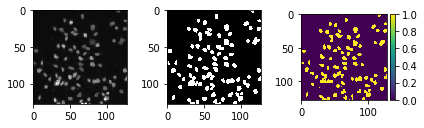

In [30]:
ix = random.randint(0, len(preds_train_t))

plt.subplot(131)
imshow(X_train[ix])
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix]));

#### Perform a sanity check on some random validation samples

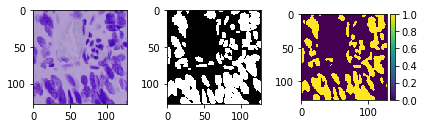

In [31]:
ix = random.randint(0, len(preds_val_t))

plt.subplot(131)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.subplot(132)
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.subplot(133)
imshow(np.squeeze(preds_val_t[ix]));

#### Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

In [32]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [33]:
new_test_ids = []
rles = []

for n, id_ in enumerate(test_ids):
    
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

#### Create submission DataFrame

In [35]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

fname ='../04.predictions/sub-dsbowl nep '+str(n_epochs)+' vsplit '+str(val_split)+' seed '+str(seed)+' thr'+str(thr)+'.csv'

sub.to_csv(fname, index=False)

nm=(time.time() - start_time)/60
print ("Total time %s min" % nm)

Total time 20.524931252 min
